## Import necessary libraries

In [1]:
import warnings
warnings.filterwarnings('ignore')

In [3]:
from sklearn.tree import DecisionTreeClassifier
import seaborn as sns
from sklearn.model_selection import TimeSeriesSplit
from scipy.sparse import *
from sklearn.model_selection import GridSearchCV,RandomizedSearchCV
from sklearn.preprocessing import StandardScaler
from sklearn.metrics import *
import pickle
from tqdm import tqdm
import numpy as np
import matplotlib.pyplot as plt
import pandas as pd
from sklearn.model_selection import train_test_split
import graphviz
from sklearn.tree import export_graphviz
from sklearn.externals import joblib
#from prettytable import PrettyTable
from wordcloud import WordCloud

## Load preprocessed data 

In [42]:
#Functions to save objects for later use and retireve it
def savetofile(obj,filename):
    pickle.dump(obj,open(filename+".pkl","wb"))
def openfromfile(filename):
    temp = pickle.load(open(filename+".pkl","rb"))
    return temp
y_train =openfromfile('y_train')
y_test =openfromfile('y_test')

count_vect =openfromfile('count_vect')
X_train_bigram = openfromfile('X_train_bigram')
X_test_bigram = openfromfile('X_test_bigram')

tf_idf_vect =openfromfile('tf_idf_vect')
X_train_tfidf =openfromfile('X_train_tfidf')
X_test_tfidf =openfromfile('X_test_tfidf')

avg_sent_vectors=openfromfile('avg_sent_vectors')
avg_sent_vectors_test=openfromfile('avg_sent_vectors_test')

tfidf_sent_vectors=openfromfile('tfidf_sent_vectors')
tfidf_sent_vectors_test=openfromfile('tfidf_sent_vectors_test')

## Save and Load Model

In [4]:
def saveModeltofile(obj,filename):
    joblib.dump(obj,open(filename+".pkl","wb"))
def openModelfromfile(filename):
    temp = joblib.load(open(filename+".pkl","rb"))
    return temp

## Standardizing data

In [44]:
def std_data(train,test,mean):
    scaler=StandardScaler(with_mean=mean)
    std_train=scaler.fit_transform(train)
    std_test=scaler.transform(test)
    return std_train, std_test

### Observation:
1. In Decision Tree based algorithm we are not dealing with distance at all.
2. So, Data Standardization is not required for DecisionTree.

## Decision Trees

### Function for hyperparameter tunning using corss validation and error plot using heatmap:

In [45]:
# find Optimal value of hyperparam by TimeSeriesSplit and 10_fold_cross _validation
# using RandomizedSearchCV and GridSearchCV.   
def DT_Classifier(x_train,y_train,TBS,params,searchMethod,vect):
    ''' FUNCTION FOR FINDING OPTIMAL VALUE OF HYPERPARAM AND DRAW HEATMAP WITH SCORE AND HYPERPARAM'''
    #INITIALIZE DECISION-TREE CLASSIFIER
    clf=DecisionTreeClassifier(class_weight='balanced',criterion='gini')
    # APPLY RANDOM OR GRID SEARCH FOR HYPERPARAMETER TUNNING
    if searchMethod=='grid':
        model=GridSearchCV(clf,\
                           cv=TBS,\
                           n_jobs=-1,\
                           param_grid=params,\
                           return_train_score=True,\
                           scoring=make_scorer(roc_auc_score,average='weighted'))
        model.fit(x_train,y_train)
    elif searchMethod=='random':
        model=RandomizedSearchCV(clf,\
                                 n_jobs=-1,\
                                 cv=TBS,\
                                 param_distributions=params,\
                                 n_iter=len(params['max_depth']),\
                                 return_train_score=True,\
                                 scoring=make_scorer(roc_auc_score,average='weighted'))
        model.fit(x_train,y_train)
    #PLOT THE PERFORMANCE OF MODEL ON CROSSVALIDATION DATA FOR EACH HYPERPARAM VALUE
    auc_results=[]
    auc_results.append(model.cv_results_['mean_test_score'])
    auc_results.append(model.cv_results_['mean_train_score'])
    data=['CV','Train'];i=0;
    plt.figure(figsize= (17,6))
    for auc in auc_results:
        auc=np.array(auc).reshape(len(params['min_samples_split']),len(params['max_depth'])) 
        cv_auc_df=pd.DataFrame(auc, np.array(params['min_samples_split']),np.array(params['max_depth']))
        cv_auc_df=cv_auc_df.round(4)
        plt.subplot(int('12'+str(i+1)))
        plt.title('Hyperparam Tunning %s-Data(%s)' %(data[i],vect))
        sns.set(font_scale=1.4)#for label size
        ax=sns.heatmap(cv_auc_df, annot=True,annot_kws={"size": 12}, fmt='g',) 
        ax.set(xlabel='Depth-Values', ylabel='Min #Samples to split')
        i+=1
    plt.show()
    return model

### Function which calculate performance on test data with optimal hyperparam : 

In [175]:
# ============================== Decision Tree with optimal depth and optimalmin_samples_split=======================

def test_performance(x_train,y_train,x_test,y_test,optimal,vect,summarize):
    '''FUNCTION FOR TEST PERFORMANCE(PLOT ROC CURVE FOR BOTH TRAIN AND TEST) WITH OPTIMAL HYPERPARAM'''
    #INITIALIZE DECISION TREE WITH OPTIMAL VALUE OF HYPERPARAMS
    clf=DecisionTreeClassifier(min_samples_split=optimal['min_samples_split'],\
                               max_depth=optimal['max_depth'],\
                               class_weight='balanced',\
                               criterion='gini')
    clf.fit(x_train,y_train)
        
    train_prob=clf.predict_proba(x_train)[:,1]
    test_prob=clf.predict_proba(x_test)[:,1]
    y_pred=clf.predict(x_test)
    
    fpr_test, tpr_test, threshold_test = roc_curve(y_test, test_prob,pos_label=1)
    fpr_train, tpr_train, threshold_train = roc_curve(y_train, train_prob,pos_label=1)
    auc_score_test=auc(fpr_test, tpr_test)
    auc_score_train=auc(fpr_train, tpr_train)
    
    f1=f1_score(y_test,y_pred,average='weighted')
    
    #ADD RESULTS TO PRETTY TABLE
    summarize.add_row([vect, optimal['max_depth'],optimal['min_samples_split'],\
                       '%.3f' %auc_score_test,'%.3f' %auc_score_train,'%.3f' %f1])
    
    plt.figure(1,figsize=(14,5))
    plt.subplot(121)
    plt.title('ROC Curve (%s)' %vect)
    #IDEAL ROC CURVE
    plt.plot([0,1],[0,1],'k--')
    #ROC CURVE OF TEST DATA
    plt.plot(fpr_test, tpr_test , 'b', label='Test_AUC= %.2f' %auc_score_test)
    #ROC CURVE OF TRAIN DATA
    plt.plot(fpr_train, tpr_train , 'g', label='Train_AUC= %.2f' %auc_score_train)
    plt.xlim([-0.1,1.1])
    plt.ylim([-0.1,1.1])
    plt.xlabel('False Positive Rate')
    plt.ylabel('True Positive Rate')
    plt.grid(True)
    plt.legend(loc='lower right')
    
    #PLOT CONFUSION MATRIX USING HEATMAP
    plt.subplot(122)
    plt.title('Confusion-Matrix(Test Data)')
    df_cm = pd.DataFrame(confusion_matrix(y_test, y_pred), ['Negative','Positive'],['Negative','Positive'])
    sns.set(font_scale=1.4)#for label size
    sns.heatmap(df_cm,cmap='gist_earth', annot=True,annot_kws={"size": 16}, fmt='g')
    plt.show()
    return clf


### Function which print top important features (feature importance):

In [5]:
def feature_importance(vectorizer,clf,n):
    '''FUNCTION FOR OVERALL FEATURE IMPORTANCE'''
    # FEATURE IMPORTANCES FROM DECISION TREE
    fe_importances = clf.feature_importances_
    
    # INDEX OF SORTED IMPORTANT FEATURES
    indices = np.argsort(fe_importances)[::-1][:n]

    # FEATURE NAMES
    names = vectorizer.get_feature_names()
    names=np.array(names)
    
    #WORDCLOUD PLOT
    wordcloud = WordCloud(max_font_size=50, max_words=100,collocations=False).\
    generate(str(names[indices]))
    plt.figure(1,figsize=(14,13))
    plt.title("WordCloud(Important Feature)")
    plt.imshow(wordcloud, interpolation="bilinear")
    plt.axis("off")
    
    #BAR CHART 
    plt.figure(2,figsize=(13,8))
    sns.set(rc={'figure.figsize':(11.7,8.27)})
    plt.title("Feature Importance")
    # ADD BARS
    plt.bar(range(n), fe_importances[indices])
    # FEATURE NAMES ON X AXIS
    plt.xticks(range(n), names[indices], rotation=70)
    # Show plot
    plt.show()

### Function for visualizing tree:

In [48]:
def visualizeDecisionTree(clf,vect,treeName):
    export_graphviz(clf, out_file=treeName+".dot",feature_names=vect.get_feature_names(),filled=True,proportion=True)

### Initialization of common objects required for all vectorization:

In [102]:
#(best depth in range [1, 5, 10, 50, 100, 500], and the best min_samples_split in range [5, 10, 100, 500])
#VECTORIZER
vect=['BoW','TF-IDF','AVG-W2V','TFIDF-W2V']
#OBJECT FOR TIMESERIES CROSS VALIDATION
TBS=TimeSeriesSplit(n_splits=10)
#METHOD USE FOR HYPER PARAMETER TUNNING
searchMethod='grid'
#RANGE OF VALUES FOR HYPERPARAM
samples=[5, 10, 100, 500]
depth=[1, 5, 10, 50, 100, 500]
params={'max_depth':depth,'min_samples_split':samples}
#INITIALIZE PRETTY TABLE OBJECT
summarize = PrettyTable()
summarize.field_names = ['Vectorizer', 'Optimal-Depth', 'Optimal #Samples', 'Test(AUC)','Train(AUC)','Test(f1-score)']

### [1.1] Applying Decision Trees on BOW,<font color='red'> SET 1</font>

#### [1.1.1] Hyperparam tunning and plot Heatmap for hyperparam:

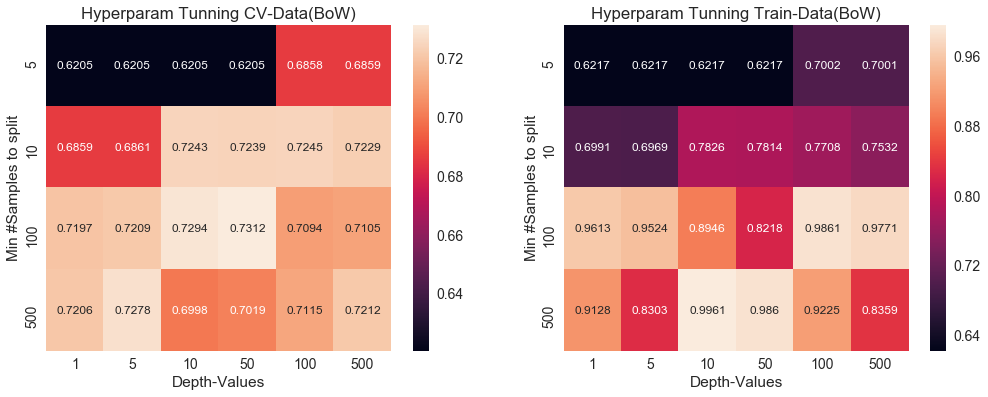

Wall time: 12min 8s
{'max_depth': 50, 'min_samples_split': 500}


In [103]:
#TRAIN AND TEST DATA
train=X_train_bigram; test=X_test_bigram;
#HYPERPARAMS TUNNING
%time model=DT_Classifier(train,y_train,TBS,params,searchMethod,vect[0])
print(model.best_params_)
#SAVE CURRENT STATE OF MODEL 
saveModeltofile(model,'model_bow_dt')

### Observation:
1. From the above heatmaps we pick optimal value of hyperparam such that our model is not overfit and underfit.
2. We pick optimal value of hyperparams:
        a. max_depth=50
        b. min_smples_split=500
3. for those optimal hyperparam, model performance:
        a. auc for crossvalidation data is .7019 and 
        b. auc for train data is .9860  
        

In [140]:
best_params={'max_depth':50,'min_samples_split':500}

#### [1.1.2] Performance on test data with optimal value of hyperparam:

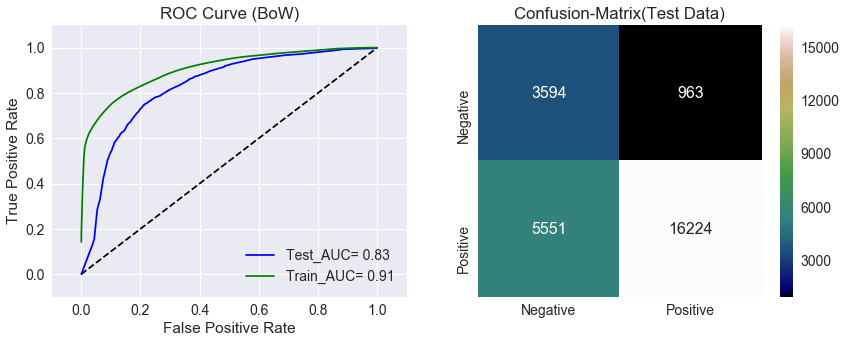

In [141]:
clf=test_performance(train,y_train,test,y_test,best_params,vect[0],summarize)

#### [1.1.3] Top 20 important features:

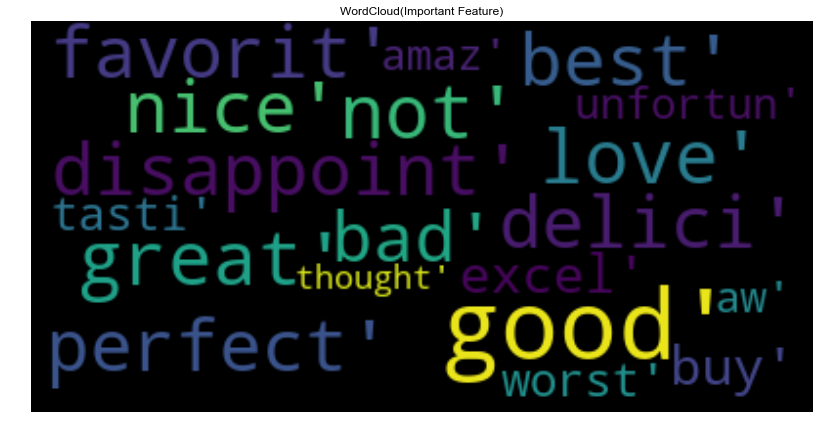

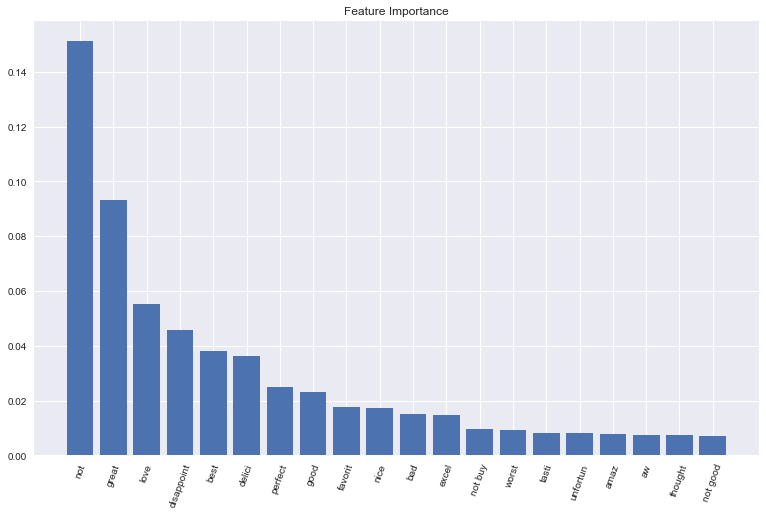

In [7]:
no_of_imp_features=20
feature_importance(count_vect,clf,no_of_imp_features)

### Observation:
1. Decision Tree give feature importance based on reduction in entroy or gini impurity due to a feature in whole Decision Tree.
2. We can't get class based feature importance in Decision Tree.

#### [1.1.5]Graphviz visualization of Decision Tree:

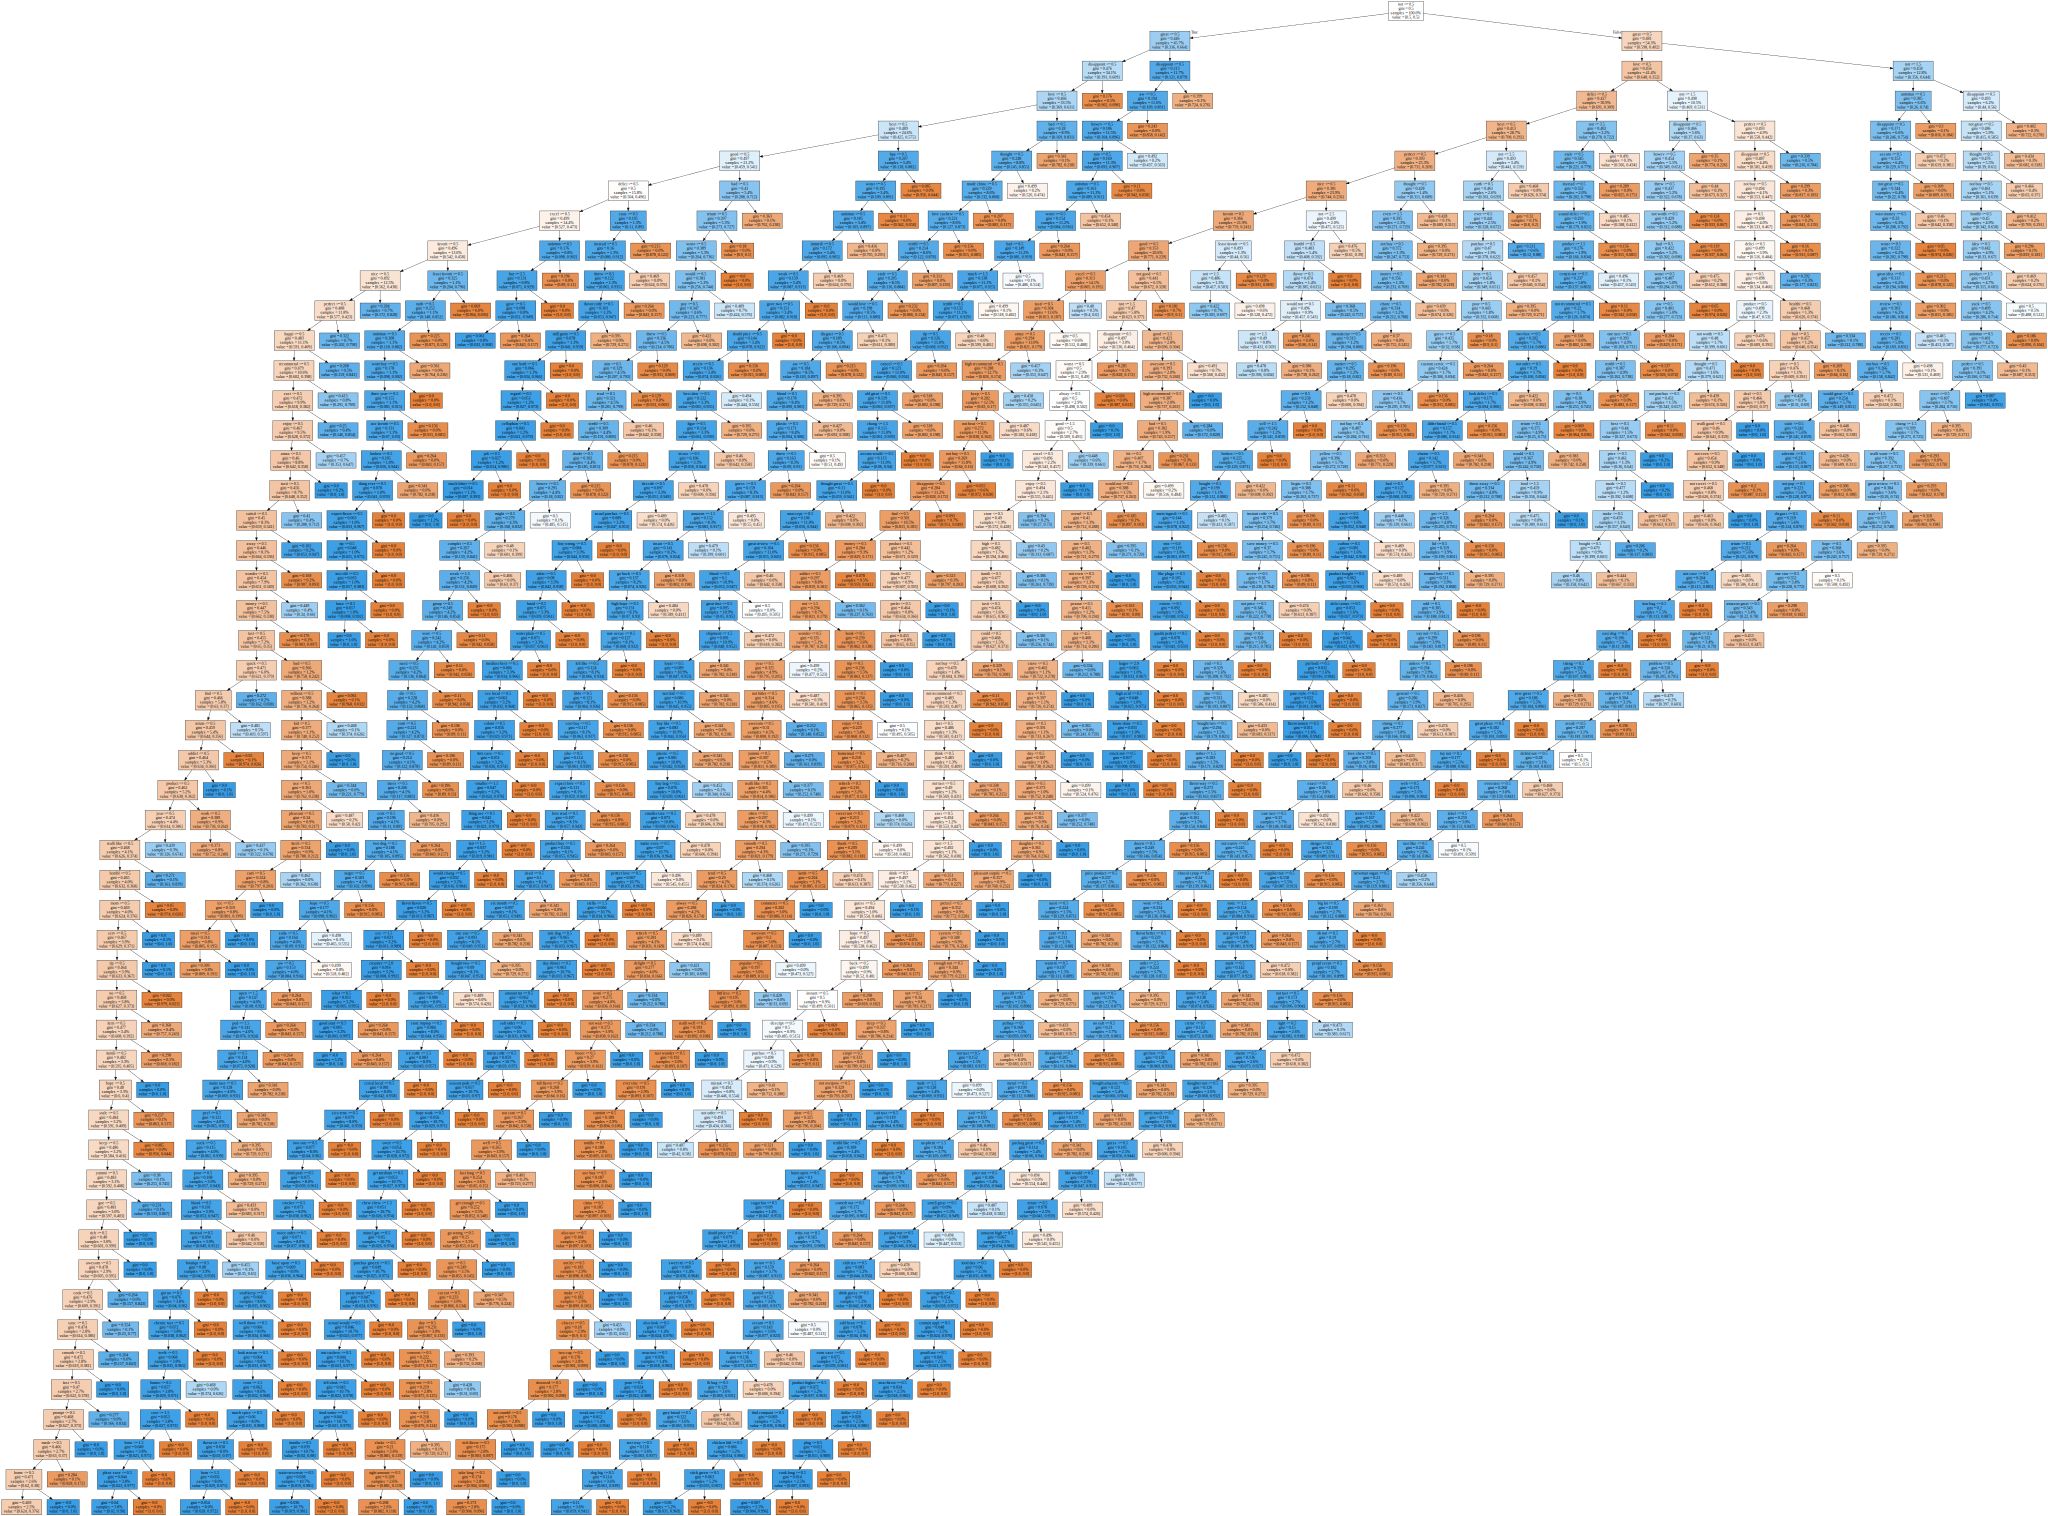

In [144]:
treeName='decision_bow'
visualizeDecisionTree(clf,count_vect,treeName)
with open(treeName+'.dot') as f:
    dot_graph = f.read()
graphviz.Source(dot_graph)

### Note: 
1. Please check the graph_bow.png to visualize the whole graph.

### [2.1] Applying Decision Tree on TFIDF,<font color='red'> SET 2</font>

#### [2.1.1] Hyperparam tunning and plot Heatmap for hyperparam:

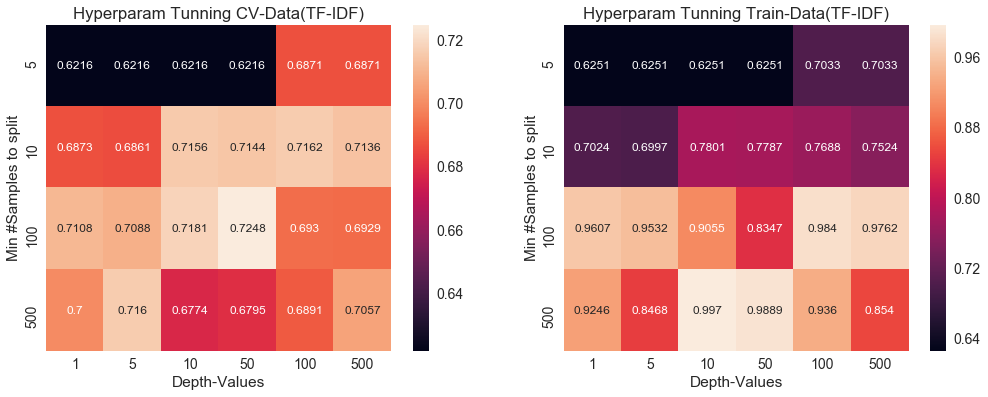

Wall time: 13min 25s
{'max_depth': 50, 'min_samples_split': 500}


In [145]:
#TRAIN AND TEST DATA
train=X_train_tfidf; test=X_test_tfidf;
#HYPERPARAMS TUNNING
%time model=DT_Classifier(train,y_train,TBS,params,searchMethod,vect[1])
print(model.best_params_)
#SAVE CURRENT STATE OF MODEL 
saveModeltofile(model,'model_tfidf_dt')

### Observation:
1. From the above heatmaps we pick optimal value of hyperparam such that our model is not overfit and underfit.
2. We pick optimal value of hyperparams:
        a. max_depth=50
        b. min_smples_split=500
3. for those optimal hyperparam, model performance:
        a. auc for crossvalidation data is .6795 and 
        b. auc for train data is .9889  
        

In [161]:
best_params={'max_depth':50,'min_samples_split':500}

#### [2.1.2] Performance on test data with optimal value of hyperparam:

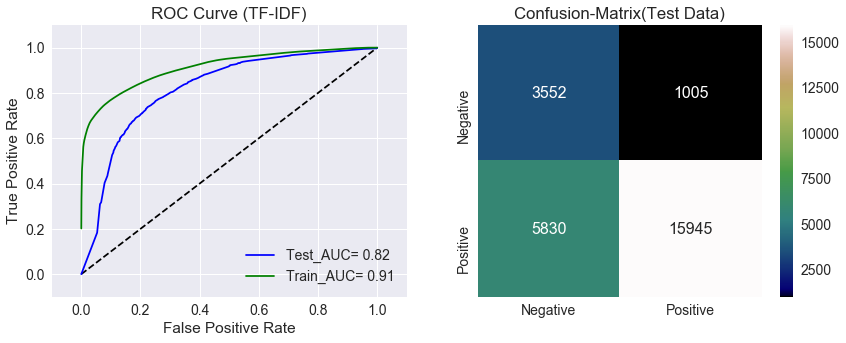

In [162]:
clf=test_performance(train,y_train,test,y_test,best_params,vect[1],summarize)

#### [2.1.3] Top 20 important features:

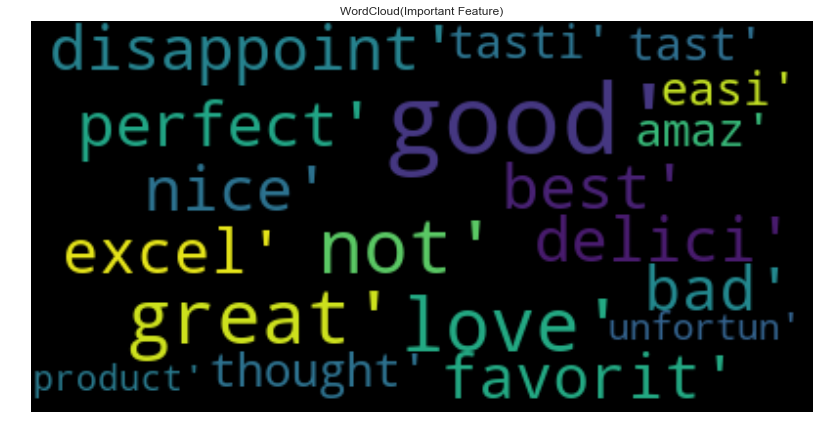

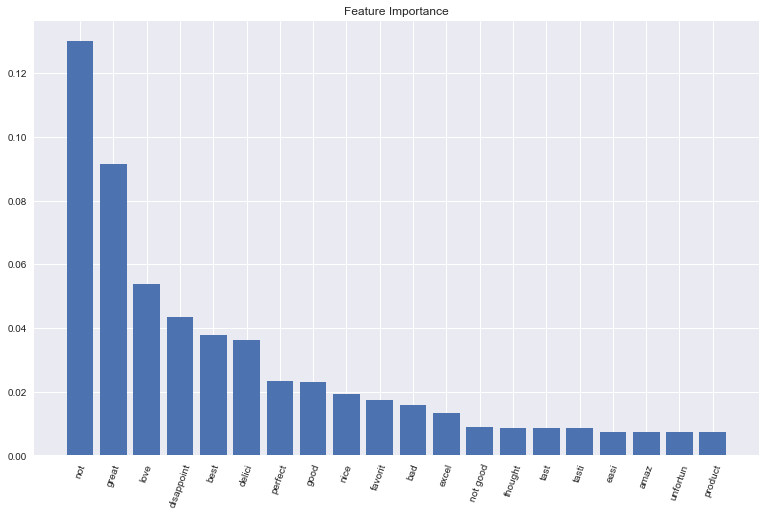

In [8]:
no_of_imp_features=20
feature_importance(tf_idf_vect,clf,no_of_imp_features)

### Observation:
1. Decision Tree give feature importance based on reduction in entroy or gini impurity due to a feature in whole Decision Tree.
2. We can't get class based feature importance in Decision Tree.

#### [2.1.4] Graphviz visualization of Decision Tree:

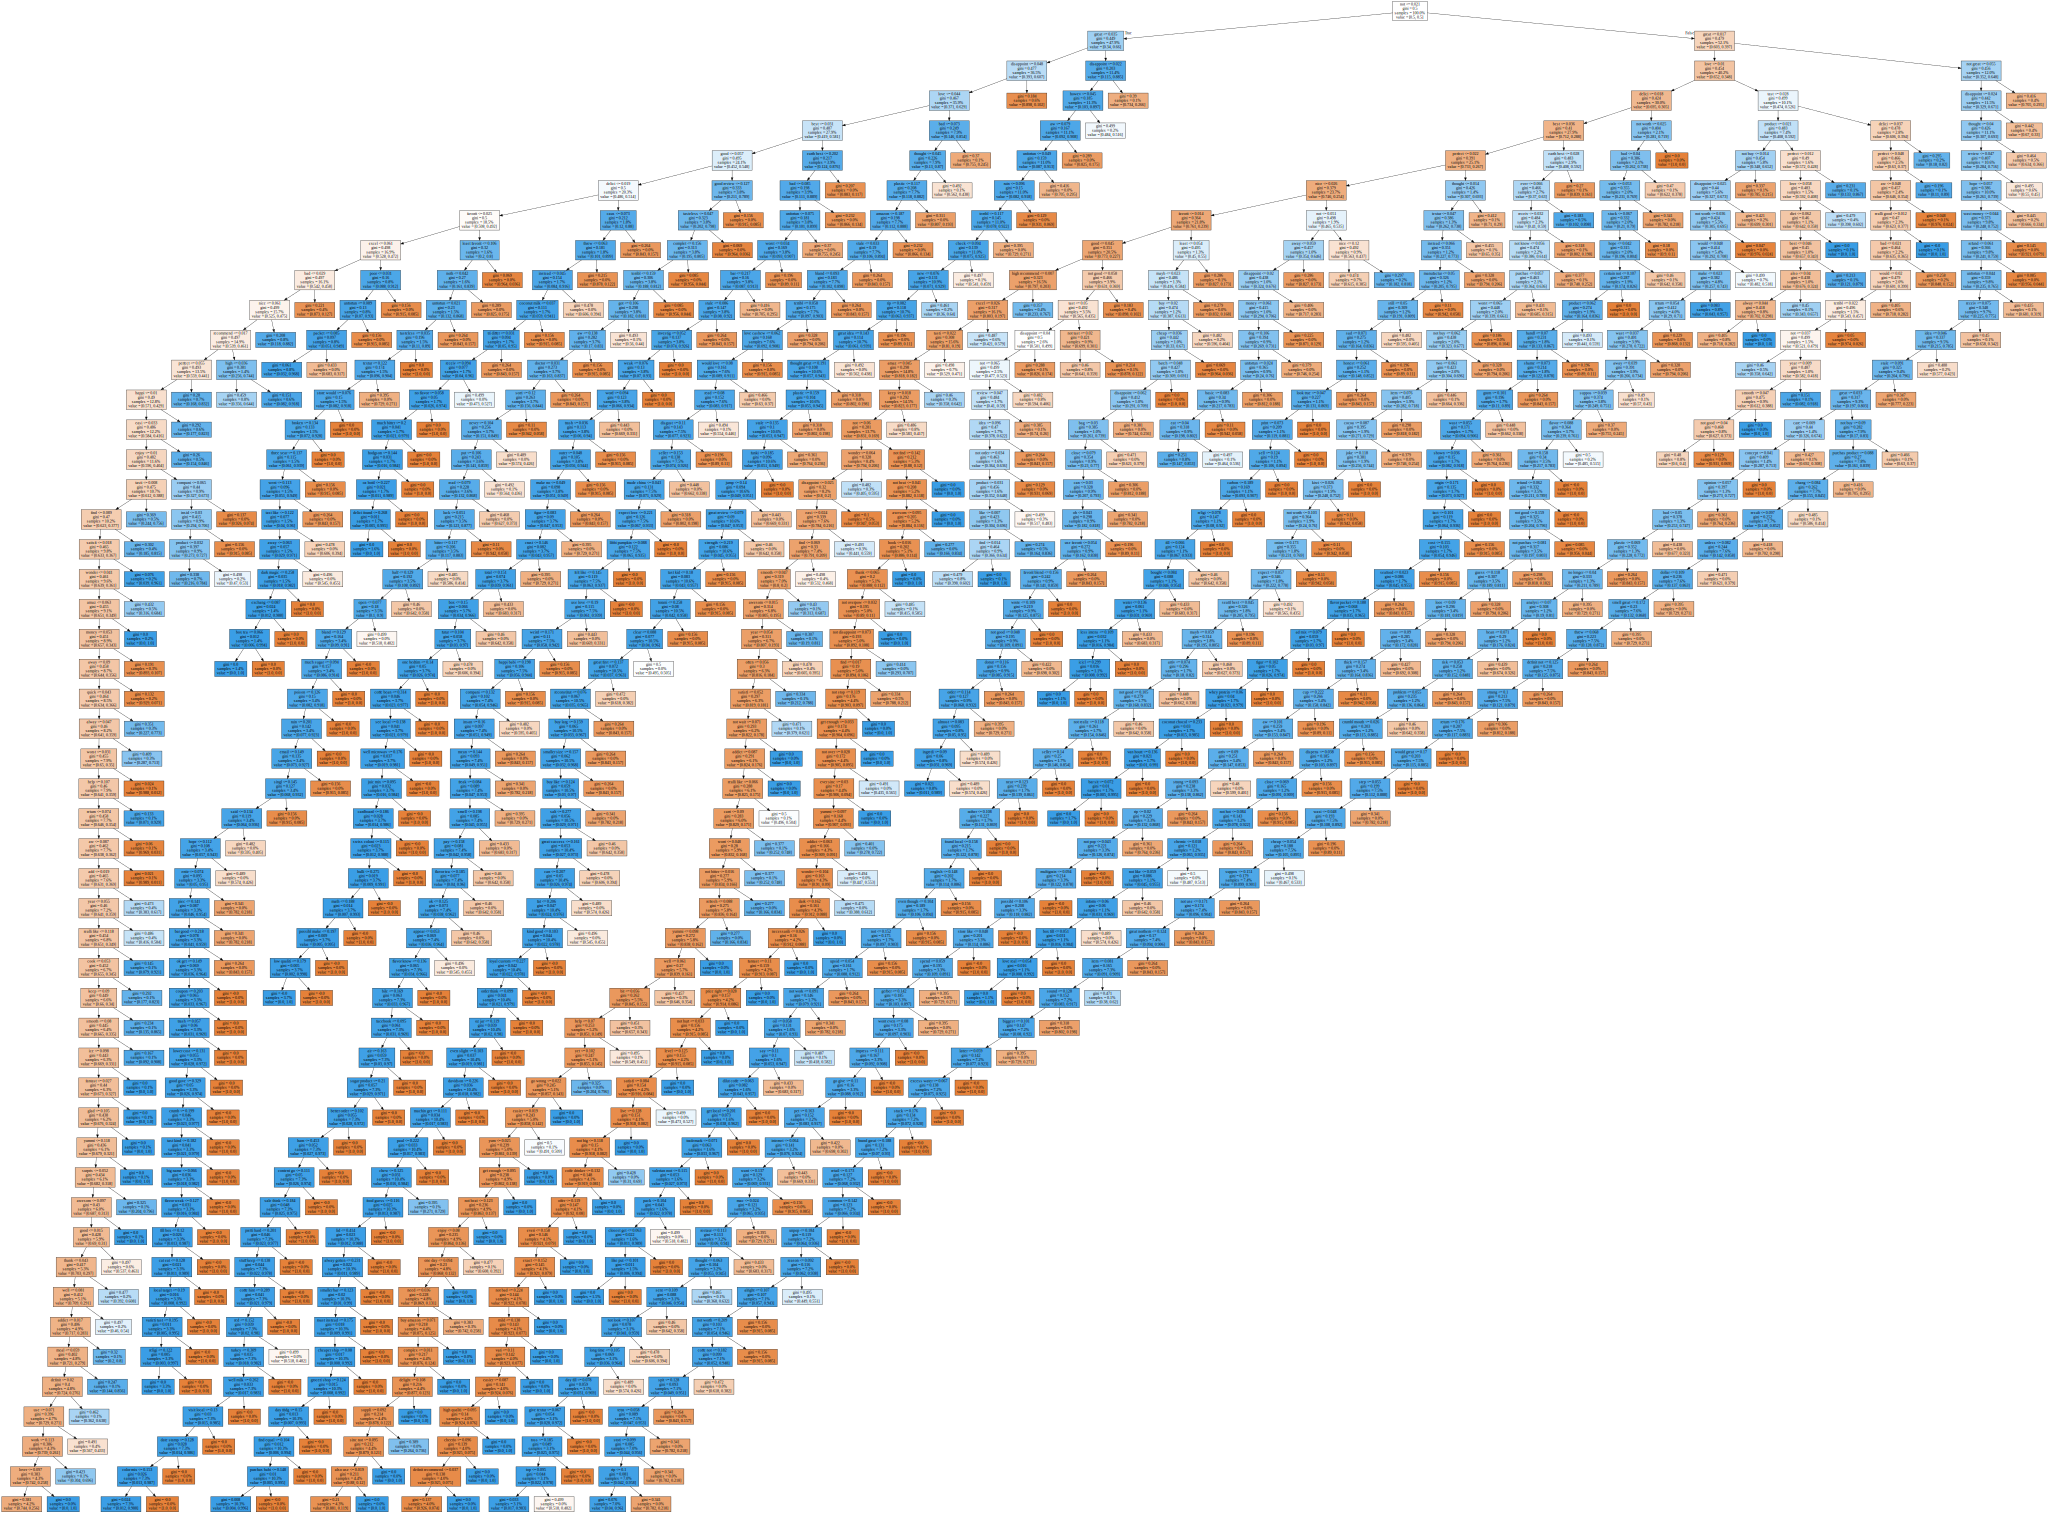

In [163]:
treeName='decision_tfidf'
visualizeDecisionTree(clf,tf_idf_vect,treeName)
with open(treeName+'.dot') as f:
    dot_graph = f.read()
graphviz.Source(dot_graph)

### Note: 
1. Please check the graph_tfidf.png to visualize the whole graph.

### [3.1] Applying Decision Tree on AVG-W2V,<font color='red'> SET 3</font>

#### [3.1.1] Hyperparam tunning and plot Heatmap for hyperparam:

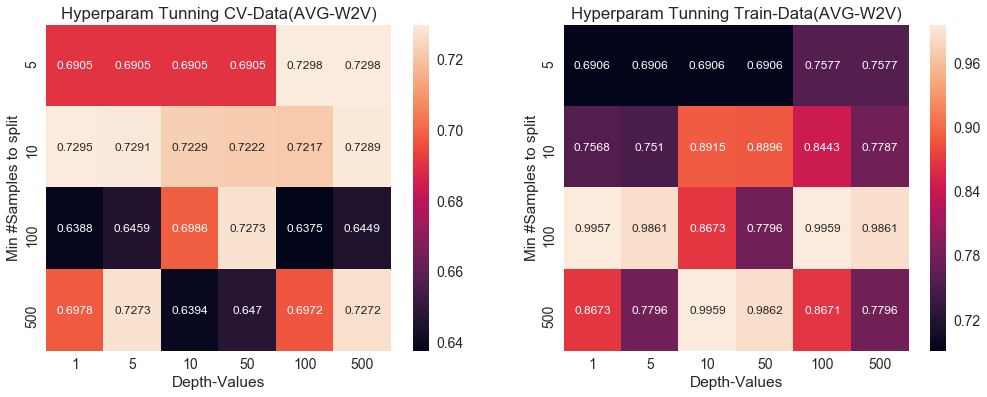

Wall time: 6min 11s
{'max_depth': 5, 'min_samples_split': 5}


In [164]:
#TRAIN AND TEST DATA
train=avg_sent_vectors; test=avg_sent_vectors_test;
#HYPERPARAMS TUNNING
%time model=DT_Classifier(train,y_train,TBS,params,searchMethod,vect[2])
print(model.best_params_)
#SAVE CURRENT STATE OF MODEL 
saveModeltofile(model,'model_avgw2v_dt')

### Observation:
1. From the above heatmaps we pick optimal value of hyperparam such that our model is not overfit and underfit.
2. We pick optimal value of hyperparams:
        a. max_depth=5
        b. min_smples_split=5
3. for those optimal hyperparam, model performance:
        a. auc for crossvalidation data is .6905 and 
        b. auc for train data is .6906  
        

In [173]:
best_params={'max_depth':5,'min_samples_split':5}

#### [3.1.2] Performance on test data with optimal value of hyperparam:

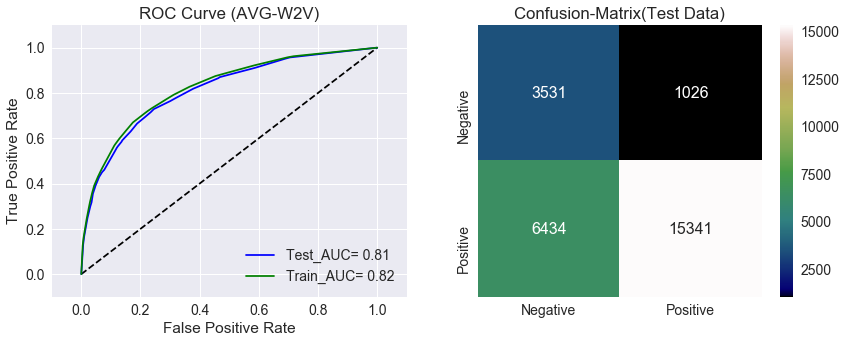

In [176]:
clf=test_performance(train,y_train,test,y_test,best_params,vect[2],summarize)

### [4.1] Applying Decision Tree on TFIDF-W2V,<font color='red'> SET 4</font>

#### [4.1.1] Hyperparam tunning and plot Heatmap for hyperparam:

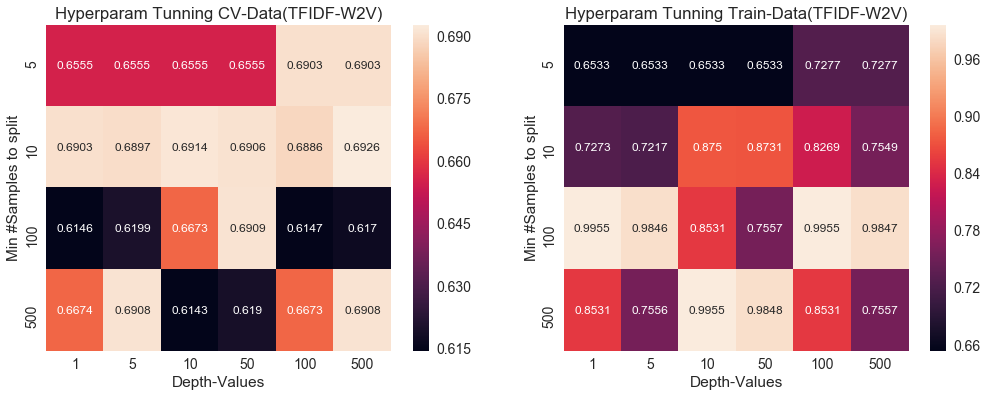

Wall time: 6min 10s
{'max_depth': 10, 'min_samples_split': 500}


In [178]:
# TRAIN AND TEST DATA
train=tfidf_sent_vectors; test=tfidf_sent_vectors_test;
#HYPERPARAMS TUNNING
%time model=DT_Classifier(train,y_train,TBS,params,searchMethod,vect[3])
print(model.best_params_)
#SAVE CURRENT STATE OF MODEL 
saveModeltofile(model,'model_tfidfw2v_dt')

### Observation:
1. From the above heatmaps we pick optimal value of hyperparam such that our model is not overfit and underfit.
2. We pick optimal value of hyperparams:
        a. max_depth=10
        b. min_smples_split=500
3. for those optimal hyperparam, model performance:
        a. auc for crossvalidation data is .6143 and 
        b. auc for train data is .9955  
        

In [179]:
best_params={'max_depth':10,'min_samples_split':500}

#### [4.1.2] Performance on test data with optimal value of hyperparam:

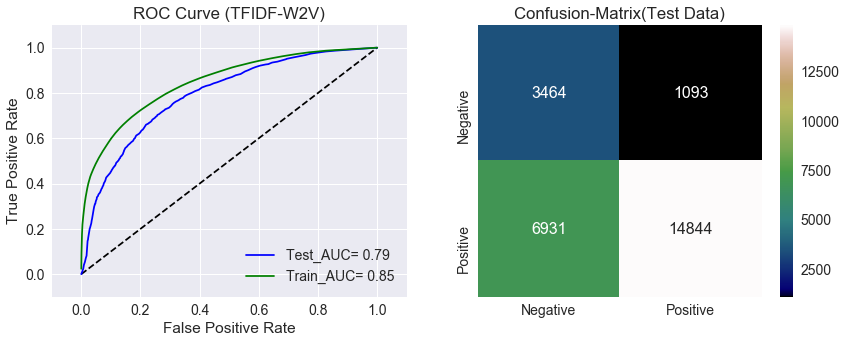

In [180]:
clf=test_performance(train,y_train,test,y_test,best_params,vect[3],summarize)

### Observation:
1. We can't get feature importance in case of AVG-W2V and TFIDF-W2V vectorizer.
2. Because in case of AVG-W2V and TFIDF-W2V vectors the dimension of a vector is not representd by a feature. 

## Conclusion:

In [182]:
print(summarize) 

+------------+---------------+------------------+-----------+------------+----------------+
| Vectorizer | Optimal-Depth | Optimal #Samples | Test(AUC) | Train(AUC) | Test(f1-score) |
+------------+---------------+------------------+-----------+------------+----------------+
|    BoW     |       50      |       500        |   0.828   |   0.905    |     0.779      |
|   TF-IDF   |       50      |       500        |   0.820   |   0.913    |     0.771      |
|  AVG-W2V   |       5       |        5         |   0.811   |   0.822    |     0.749      |
| TFIDF-W2V  |       10      |       500        |   0.792   |   0.846    |     0.731      |
+------------+---------------+------------------+-----------+------------+----------------+


### 1. from the above table we can observe that the optimal performance is give by:
               a. BoW vectorizer
               b. f1-score=.779 and auc=.828